In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('../pueo-dsp-python'))
if module_path not in sys.path:
    sys.path.append(module_path)
from dsp.iir_biquad import test, iir_biquad
from scipy.special import eval_chebyu
import scipy.signal as signal
import numpy as np
from matplotlib import pyplot as plt

In [2]:
#ASSUME POLE AND ZERO ON SAME SIDE
def bqnotchresponse(zradius, pradius, zfrequency, pfrequency, evalfreq):
    prct=pradius*np.cos(np.pi*pfrequency)
    prst=pradius*np.sin(np.pi*pfrequency)
    toppole=complex(prct,prst)
    botpole=complex(prct,-prst)
#     topzero=zradius*complex(np.cos(np.pi*frequency),np.sin(np.pi*frequency))
#     botzero=topzero.conjugate()
    zrct=zradius*np.cos(np.pi*zfrequency)
    zrst=zradius*np.sin(np.pi*zfrequency)
    topzero=complex(zrct,zrst)
    botzero=complex(zrct,-zrst)

    z=np.exp(1J*np.pi*evalfreq)
    # These normalizations are just the maximum value (determined by what side the notch is on)
    if (pfrequency<0.5):
        norm=abs(((-1-topzero)*(-1-botzero))/((-1-toppole)*(-1-botpole)))
    else:
        norm=abs(((1-topzero)*(1-botzero))/((1-toppole)*(1-botpole)))
    # https://www.dsprelated.com/freebooks/filters/Pole_Zero_Analysis_I.html
    # This is using the length of the vectors between the point on the unit circle and the 
    response=((z-topzero)*(z-botzero))/((z-toppole)*(z-botpole))/norm
    return abs(response)
                    

In [3]:
def zeroresponse(zradius, zfrequency, evalfreq):
    zrct=zradius*np.cos(np.pi*zfrequency)
    zrst=zradius*np.sin(np.pi*zfrequency)
    topzero=complex(zrct,zrst)
    botzero=complex(zrct,-zrst)
    z=np.exp(1J*np.pi*evalfreq)
    # These normalizations are just the maximum value (determined by what side the notch is on)
    if (zfrequency<0.5):
        norm=abs(((-1-topzero)*(-1-botzero))/(1))
    else:
        norm=abs(((1-topzero)*(1-botzero))/(1))
    # https://www.dsprelated.com/freebooks/filters/Pole_Zero_Analysis_I.html
    # This is using the length of the vectors between the point on the unit circle and the 
    response=((z-topzero)*(z-botzero))/(1)/norm
    return abs(response)

In [4]:
def plot_filter(init_radius=0.5, init_frequency=0.25):
    plt.clf()
    fig = plt.figure(num='Biquad Notch Response',figsize=(10,4.8))
    ax=fig.add_subplot(1,10,(1,3),projection='polar')
    ax2=fig.add_subplot(1,10,(5,10))
    ax.set_rlim(0,1.1)
    ax2.set_ylim(0.001,1.1)
    ax2.set_xlabel("Normalized Freq: (xPI radians/sample)")
    init_theta=np.pi * init_frequency
    poles = ax.scatter([init_theta,-init_theta],[init_radius,init_radius],c='red',marker="x")
    zeros = ax.scatter([init_theta,-init_theta],[1,1],c='red',marker="o")
    evalfreqs=np.linspace(0,1,10000)
    response=ax2.semilogy(evalfreqs,bqnotchresponse(1,init_radius,init_frequency, init_frequency,evalfreqs))
    fig.subplots_adjust(left=0.15, bottom=0.25,wspace=0.25,hspace=0.25)
    # axfreq = fig.add_axes([0.25, 0.1, 0.65, 0.03])
    # freq_slider = Slider(
    #     ax=axfreq,
    #     label='Freq [norm]',
    #     valmin=0.001,
    #     valmax=1,
    #     valinit=init_frequency,
    # )
    # axradius = fig.add_axes([0.05, 0.25, 0.0225, 0.63])
    # radius_slider = Slider(
    #     ax=axradius,
    #     label="Pole Radius",
    #     valmin=0,
    #     valmax=0.99,
    #     valinit=init_radius,
    #     orientation="vertical"
    # )
    plt.show()

<Figure size 640x480 with 0 Axes>

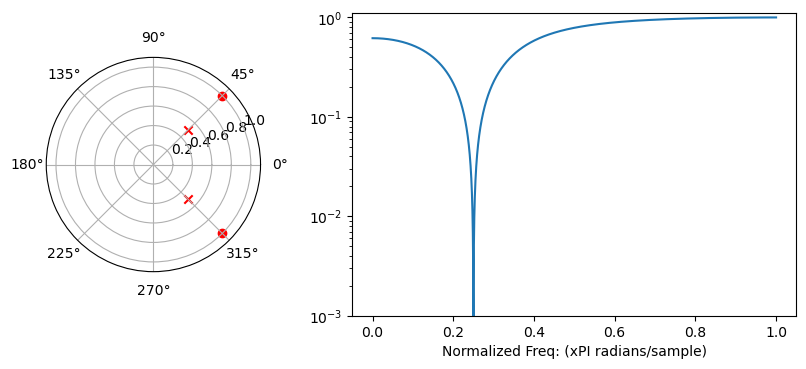

In [5]:
plot_filter()

<Figure size 640x480 with 0 Axes>

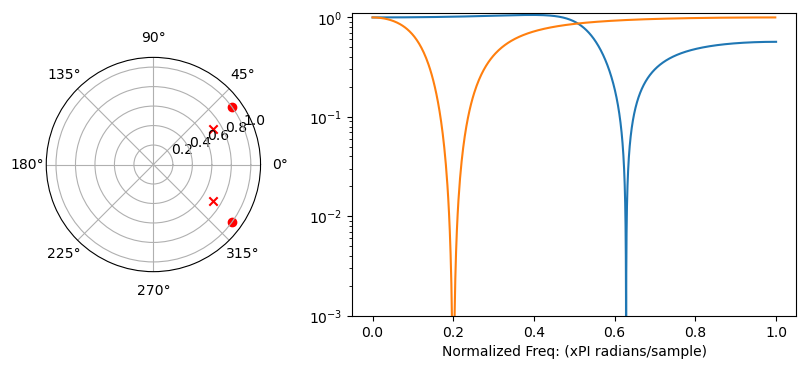

No initial conditions!
Magnitude: 0.7138105137180516 Angle: 0.5444132575124971
f/g FIRs are calculated only for sample 0 and sample 1 respectively.
f FIR: [1.0, 1.221231742082474, 0.9818815183753657, 0.5768562248826961, 0.20418151044413388, -0.04456998557629451]
g FIR: [1.0, 1.221231742082474, 0.9818815183753657, 0.5768562248826961, 0.20418151044413388, -0.04456998557629451, -0.1584659570174276]
F/G FIRs operate on f/g inputs respectively
F FIR: [1.0, 0.08074243797886962] +g* -0.17081411481443792
G FIR: [1.0, -0.12786118102824212] -f* -0.08703413863081944

As full FIRs calculated only for sample 0 and 1 respectively:
F = f + (fz^-8)+-0.17081411481443792*(gz^-7)
G = g + (gz^-8)--0.08703413863081944*(fz^-9)
Update step (matrix) coefficients: [-0.00834732  0.00804855 -0.00410094  0.00148182]
As an IIR:
y[0] =0.008048546385147515*z^-15 + -0.008347318058088889*z^-16+F[0]
y[1] =0.0014818222650764094*z^-16 + -0.004100939214669047*z^-17+G[1]


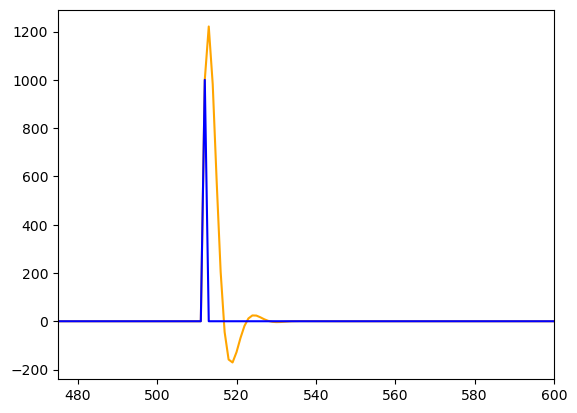

In [25]:
# The filter parameters
notch_freq = 300
sample_freq = 3000
quality_factor = 1

# Get the numerator and denominator of the transfer function
b, a = signal.iirnotch(notch_freq, quality_factor, sample_freq)
# Turn the coefficients into the cojugate zeros and poles and an overall gain
zpk = signal.tf2zpk(b,a)
zero = zpk[0][0]
pole = zpk[1][0]
mag = zpk[2]
pole_mag = np.abs(pole)
pole_angle = np.angle(pole)
zero_mag = np.abs(zero)
zero_angle = np.angle(zero)

plt.clf()
fig = plt.figure(num='Biquad Notch Response',figsize=(10,4.8))
ax=fig.add_subplot(1,10,(1,3),projection='polar')
ax2=fig.add_subplot(1,10,(5,10))
ax.set_rlim(0,1.1)
ax2.set_ylim(0.001,1.1)
ax2.set_xlabel("Normalized Freq: (xPI radians/sample)")
# init_theta=np.pi * init_frequency
poles = ax.scatter([pole_angle,-pole_angle],[pole_mag,pole_mag],c='red',marker="x")
zeros = ax.scatter([zero_angle,-zero_angle],[zero_mag,zero_mag],c='red',marker="o")
evalfreqs=np.linspace(0,1,10000)
response=ax2.semilogy(evalfreqs,bqnotchresponse(zero_mag,pole_mag, zero_angle, pole_angle,evalfreqs))
fig.subplots_adjust(left=0.15, bottom=0.25,wspace=0.25,hspace=0.25)

freqs, freqzresponse = signal.freqz(b,a)
freqs = freqs/np.pi
freqzresponse = freqzresponse/np.max(freqzresponse)
response=ax2.semilogy(freqs,freqzresponse, label="Freqz")

plt.show()


# Impulse
orig = np.zeros(1024)
orig[512] = 1000
orig_copy = np.copy(orig)

# Plot the impulse response
SAMPLES_PER_CLOCK=8
ics = np.zeros(SAMPLES_PER_CLOCK*3)
ics = ics.reshape(3,-1)

plt.clf()
plt.plot(np.arange(len(orig)), iir_biquad(orig, SAMPLES_PER_CLOCK, pole_mag, pole_angle), color="orange")
plt.plot(np.arange(len(orig_copy)), orig_copy, color="blue")
plt.xlim(475,600)
plt.show()

# Calculate from just A and B

(array([-1.+6.68896751e-09j, -1.-6.68896751e-09j]), array([-1.]), 1.0)


<Figure size 640x480 with 0 Axes>

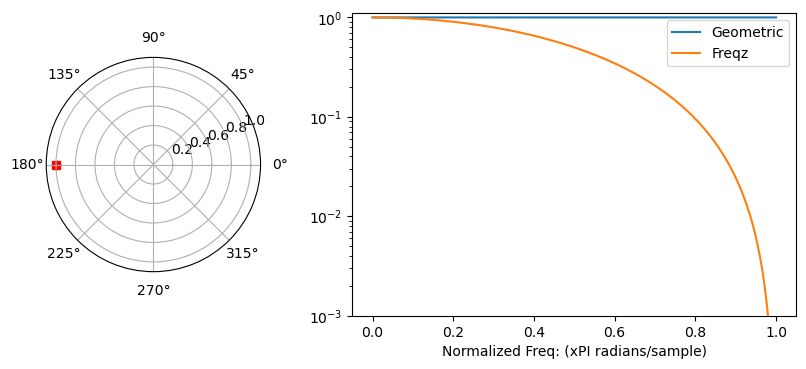

No initial conditions!
Magnitude: 1.0 Angle: 3.141592653589793
f/g FIRs are calculated only for sample 0 and sample 1 respectively.
f FIR: [1.0, -2.0, 3.0, -4.0, 5.0, -6.0]
g FIR: [1.0, -2.0, 3.0, -4.0, 5.0, -6.0, 7.0]
F/G FIRs operate on f/g inputs respectively
F FIR: [1.0, -7.0] +g* -8.0
G FIR: [1.0, 9.0] -f* -8.0

As full FIRs calculated only for sample 0 and 1 respectively:
F = f + (fz^-8)+-8.0*(gz^-7)
G = g + (gz^-8)--8.0*(fz^-9)
Update step (matrix) coefficients: [-15. -16.  16.  17.]
As an IIR:
y[0] =-16.0*z^-15 + -15.0*z^-16+F[0]
y[1] =17.0*z^-16 + 16.0*z^-17+G[1]


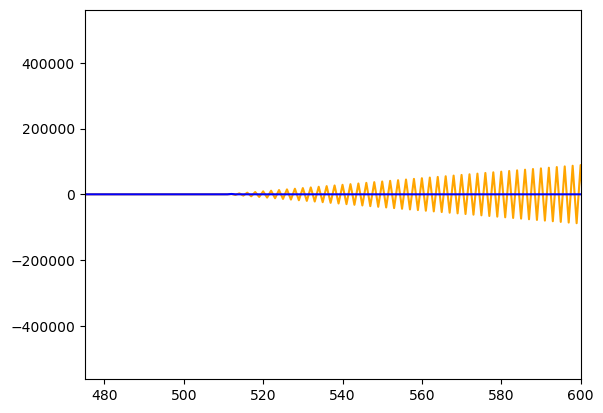

In [26]:
# The filter parameters, using A + Bz^-1 + Az^-2
A=1
B=2

b = np.array([A, B, A])
a = np.array([1,1,0])

# Get the numerator and denominator of the transfer function
# b, a = signal.iirnotch(notch_freq, quality_factor, sample_freq)
# Turn the coefficients into the cojugate zeros and poles and an overall gain
zpk = signal.tf2zpk(np.flip(b),np.flip(a))
print(zpk)
zero = zpk[0][0]
if(len(zpk[1])>0):
    pole = zpk[1][0]
else:
    pole = None
mag = zpk[2]

zero_mag = np.abs(zero)
zero_angle = np.angle(zero)

plt.clf()
fig = plt.figure(num='Biquad Notch Response',figsize=(10,4.8))
ax=fig.add_subplot(1,10,(1,3),projection='polar')
ax2=fig.add_subplot(1,10,(5,10))
ax.set_rlim(0,1.1)
ax2.set_ylim(0.001,1.1)
ax2.set_xlabel("Normalized Freq: (xPI radians/sample)")
# init_theta=np.pi * init_frequency

evalfreqs=np.linspace(0,1,10000)
zeros = ax.scatter([zero_angle,-zero_angle],[zero_mag,zero_mag],c='red',marker="o")
if not pole is None:
    pole_mag = np.abs(pole)
    pole_angle = np.angle(pole)
    poles = ax.scatter([pole_angle,-pole_angle],[pole_mag,pole_mag],c='red',marker="x")
    response=ax2.semilogy(evalfreqs,bqnotchresponse(zero_mag,pole_mag, zero_angle, pole_angle,evalfreqs), label="Geometric")
else:
    response=ax2.semilogy(evalfreqs,zeroresponse(zero_mag, zero_angle,evalfreqs), label="Geometric")

freqs, freqzresponse = signal.freqz(b,a)
freqs = freqs/np.pi
freqzresponse = freqzresponse/np.max(freqzresponse)
response=ax2.semilogy(freqs,freqzresponse, label="Freqz")

fig.subplots_adjust(left=0.15, bottom=0.25,wspace=0.25,hspace=0.25)
plt.legend()
plt.show()


# Impulse
orig = np.zeros(1024)
orig[512] = 1000
orig_copy = np.copy(orig)

# Plot the impulse response
SAMPLES_PER_CLOCK=8
ics = np.zeros(SAMPLES_PER_CLOCK*3)
ics = ics.reshape(3,-1)

plt.clf()
plt.plot(np.arange(len(orig)), iir_biquad(orig, SAMPLES_PER_CLOCK, pole_mag, pole_angle), color="orange")
plt.plot(np.arange(len(orig_copy)), orig_copy, color="blue")
plt.xlim(475,600)
plt.show()